Load the data from the load notebook.


%run "cog_wfdb-dataframe-to-cache.ipynb"

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import pandas as pd
import numpy as np
cache = 'cached_eq_ml_data.hdf'
samples = pd.read_hdf(cache, 'cached_data')

Ensure tflearn and tensorflow is installed

!pip3 install tflearn tensorflow

Remove columns that aren't needed.

isolate_millivolt_features....


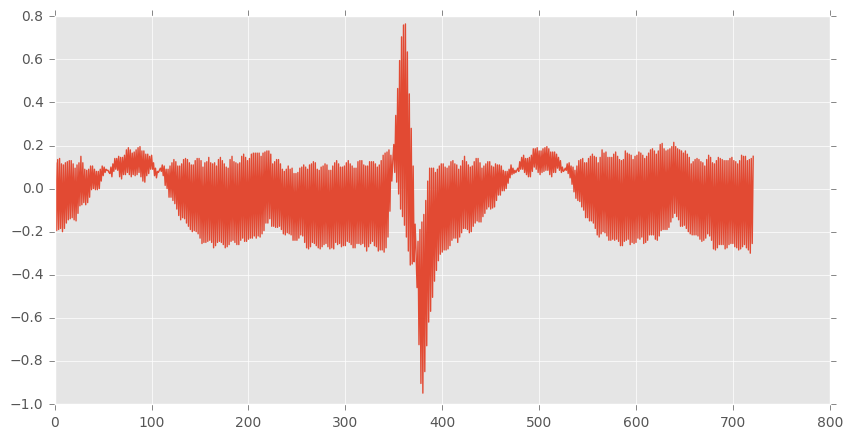

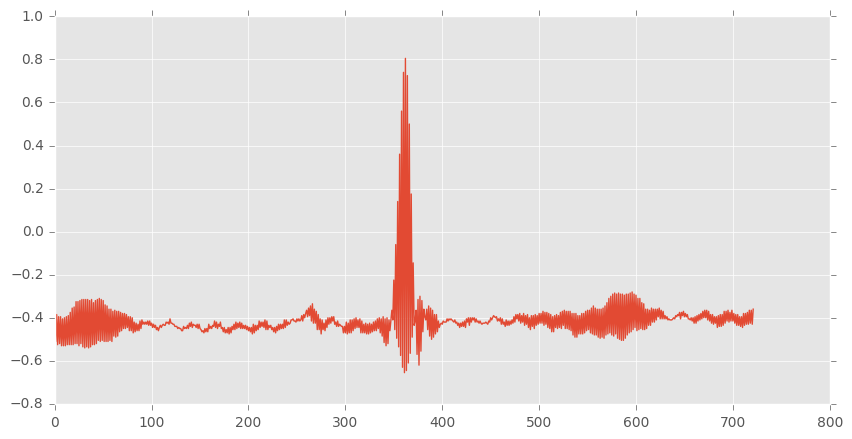

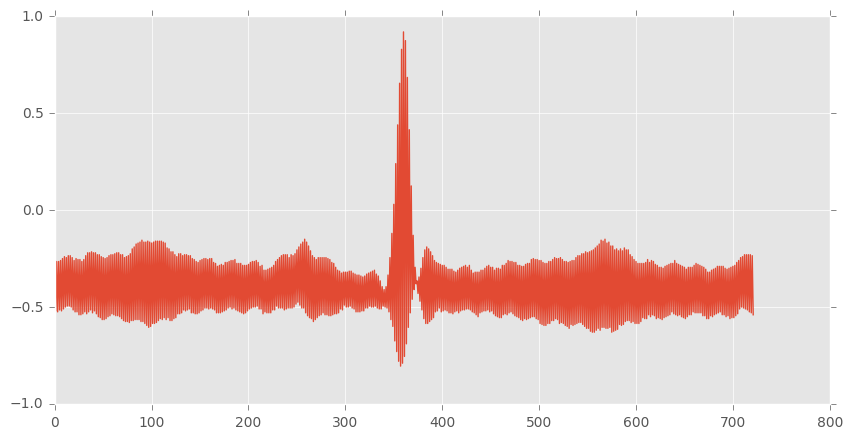

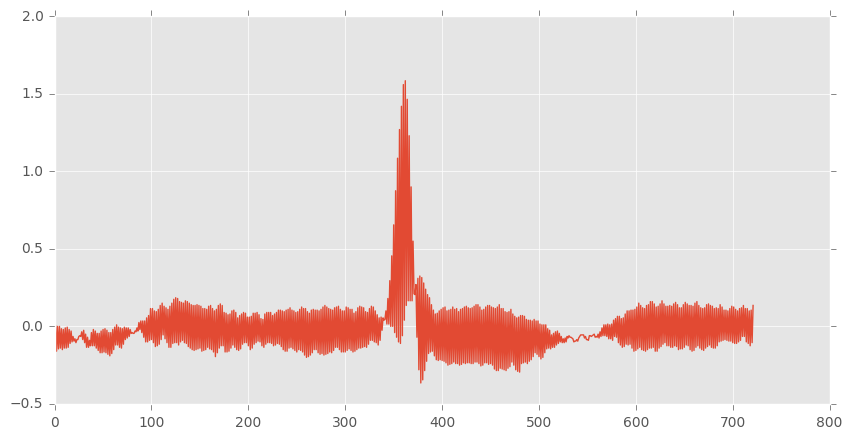

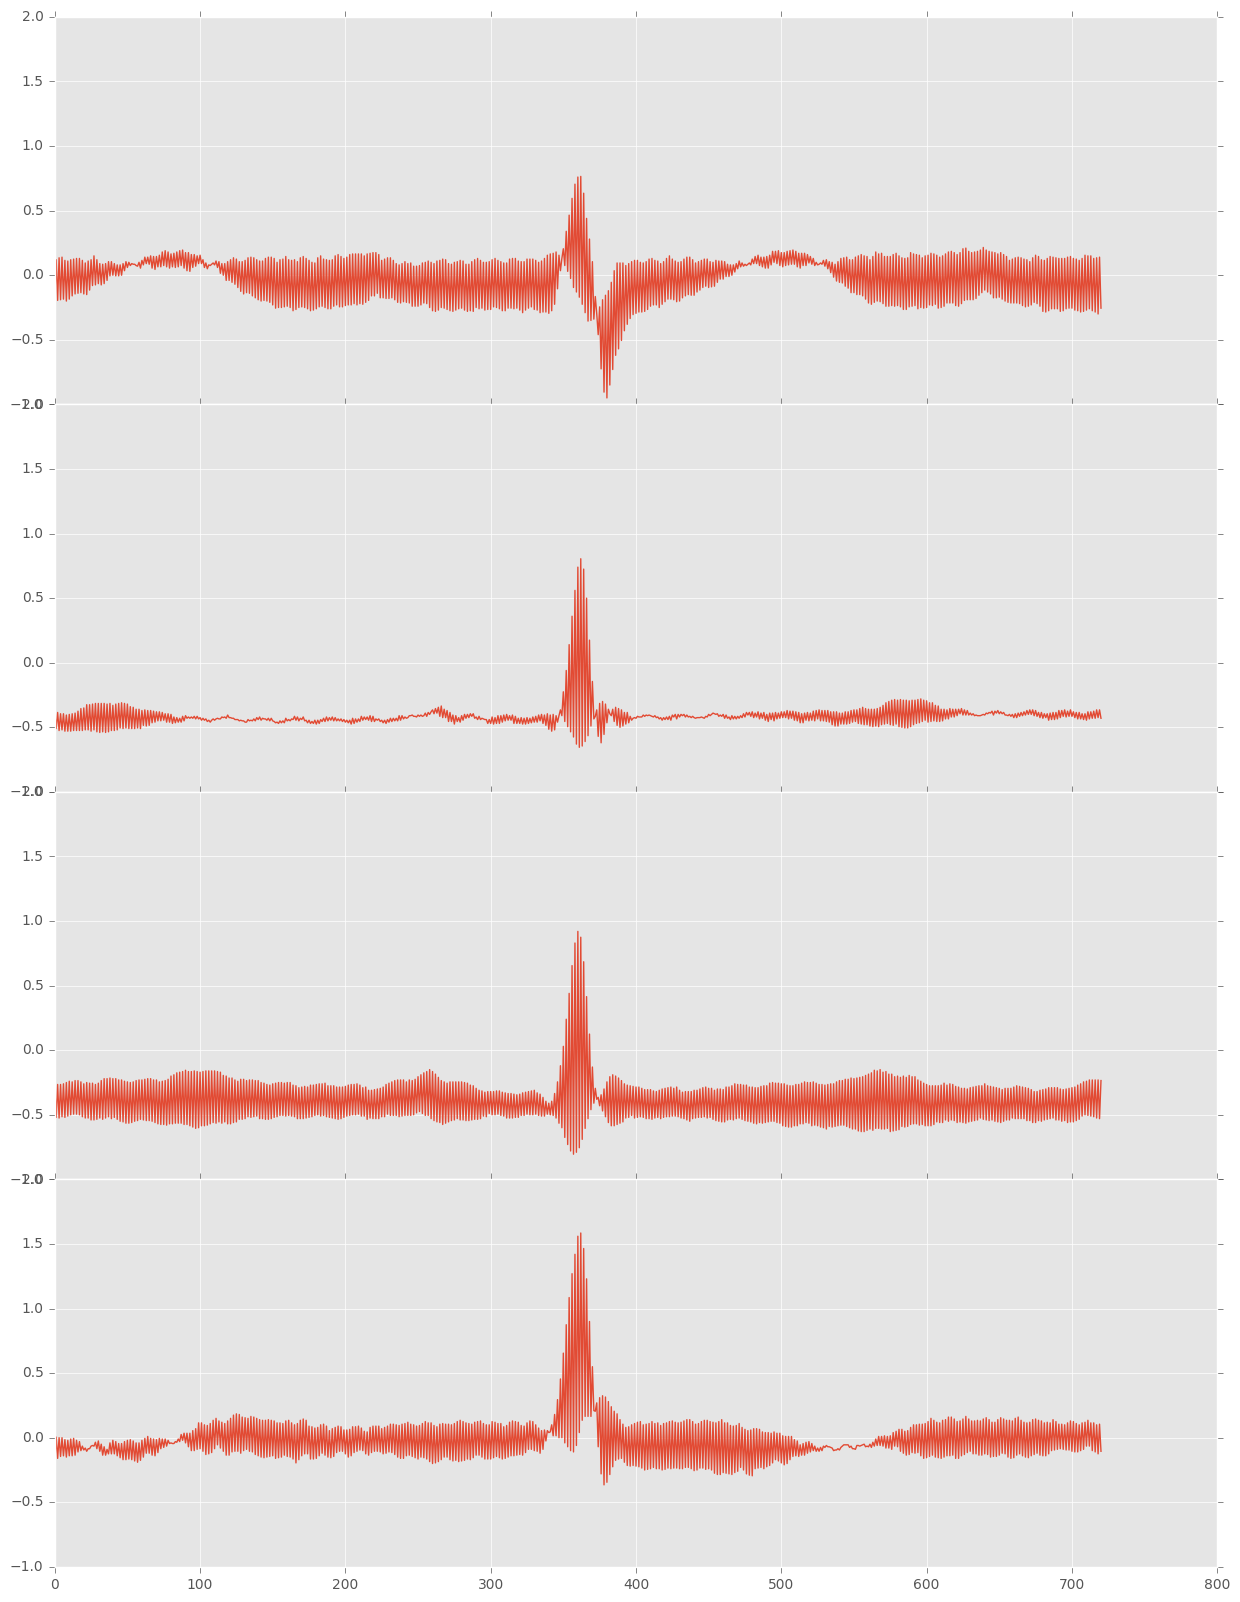

In [40]:
def isolate_millivolt_features(anEcgDataFrame):
    # trim data down
    data = anEcgDataFrame
    import re;
    columns = data.drop('labels', axis=1).columns.tolist()
    columns = list(filter(lambda x: not re.search('_max|_var', str(x)), columns))

    samples = data[columns]
    samples = samples.fillna(0)

    labels = data['labels']

    return samples, labels, columns



print('isolate_millivolt_features....')
from IPython.display import display
#display(samples)
milivoltFeatures, labels, columns = isolate_millivolt_features(samples)


def plotter(row):
    plt.figure(figsize=(10, 5))
    plt.plot(row)
    plt.show()
#print(milivoltFeatures.iloc[:,:])

milivoltFeatures.iloc[:4,:].apply(lambda x: plotter(x), axis=1 ) 

f, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(15, 20))
for rowIdx in range( len(axs) ):
    axs[rowIdx].plot( samples.iloc[rowIdx,:721] )
f.subplots_adjust(hspace=0)

Dataset Mean

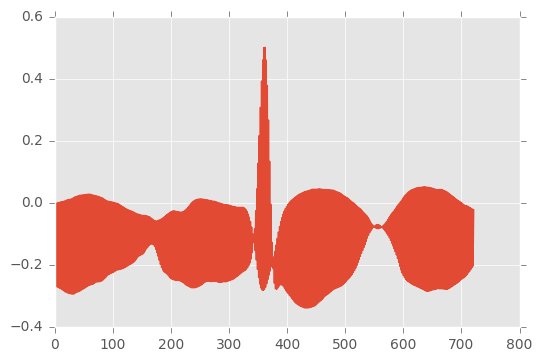

In [11]:
mean_row = np.mean(milivoltFeatures, axis=0)
plt.plot(mean_row)
plt.show()

Dataset Standard Deviation

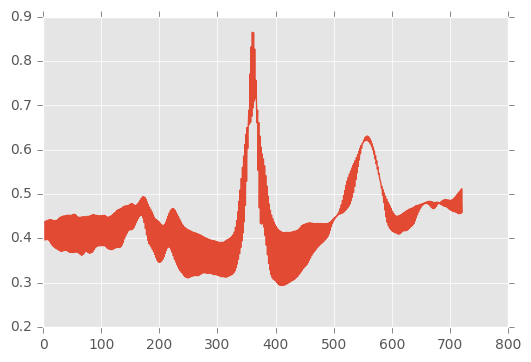

In [12]:
std_row = np.std(milivoltFeatures, axis=0)
plt.plot(std_row)
plt.show()

In [13]:
def draw_confusion_matrices(confusion_matricies,class_names):
    import matplotlib.pyplot as plt
    class_names = class_names.tolist()
    for cm in confusion_matricies:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    

Show tensorflow graph

In [14]:
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Process ECG data

In [31]:
from sklearn.cross_validation import train_test_split
x_train, x_val, y_train, y_val = \
    train_test_split(milivoltFeatures.values, labels.values, test_size=0.20,
                     random_state=np.random.randint(0, 100))

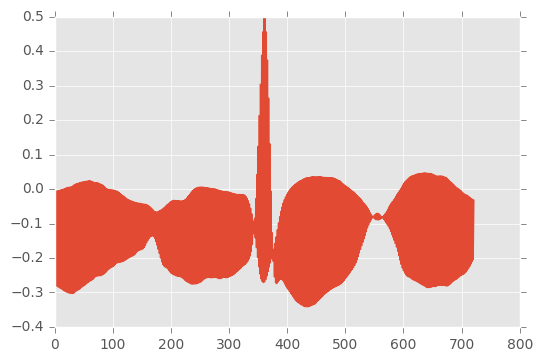

In [34]:
mean_row = np.mean(x_train, axis=0)
plt.plot(mean_row)
plt.show()

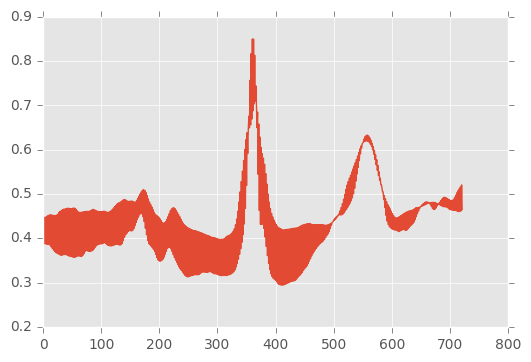

In [32]:
std_row = np.std(x_train, axis=0)
plt.plot(std_row)
plt.show()

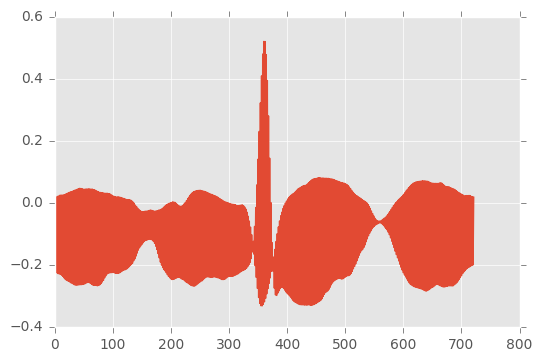

In [35]:
mean_row = np.mean(x_val, axis=0)
plt.plot(mean_row)
plt.show()

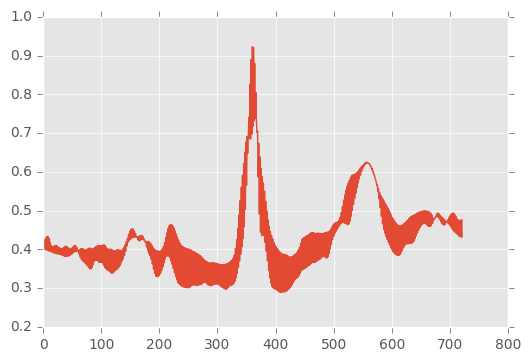

In [33]:
std_row = np.std(x_val, axis=0)
plt.plot(std_row)
plt.show()

---------------------------------
Run id: ECG DNN
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 1452
Validation samples: 364
--
Training Step: 1  | time: 1.528s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 0.67610 - val_acc: 1.0000 -- iter: 1452/1452
--
Training Step: 2  | total loss: 0.62379 | time: 1.318s
| Adam | epoch: 002 | loss: 0.62379 - acc: 0.6081 | val_loss: 0.63108 - val_acc: 1.0000 -- iter: 1452/1452
--
Training Step: 3  | total loss: 0.66615 | time: 1.127s
| Adam | epoch: 003 | loss: 0.66615 - acc: 0.9287 | val_loss: 0.55675 - val_acc: 1.0000 -- iter: 1452/1452
--
Training Step: 4  | total loss: 0.63836 | time: 1.078s
| Adam | epoch: 004 | loss: 0.63836 - acc: 0.9822 | val_loss: 0.48085 - val_acc: 1.0000 -- iter: 1452/1452
--
Training Step: 5  | total loss: 0.58039 | time: 1.065s
| Adam | epoch: 005 | loss: 0.58039 - acc: 0.9945 |

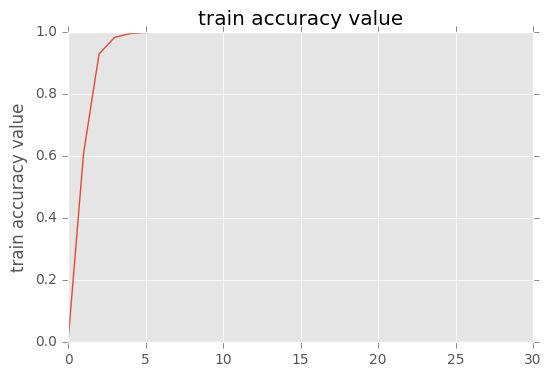

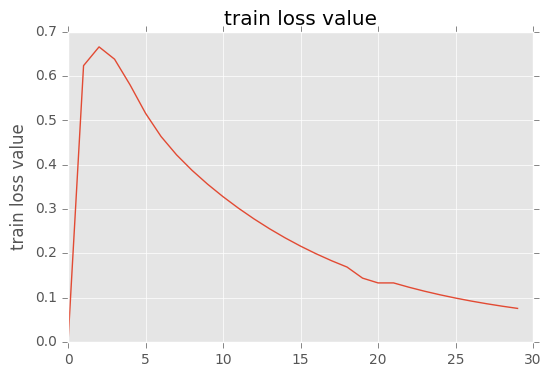

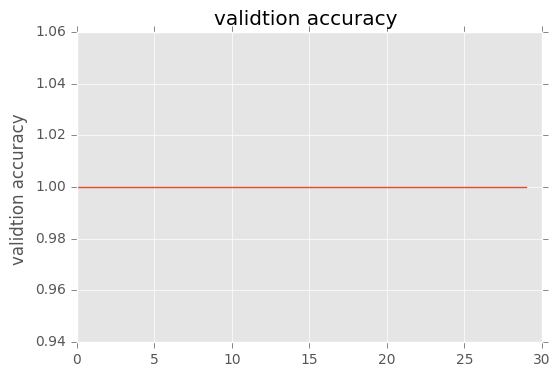

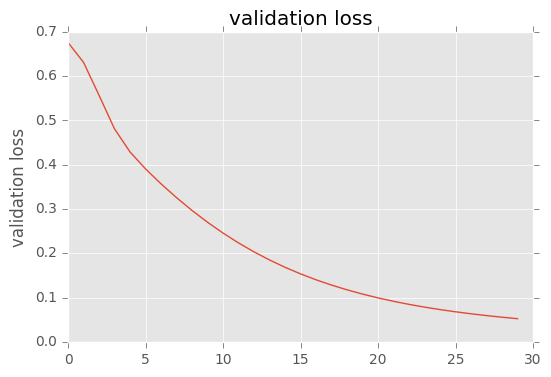

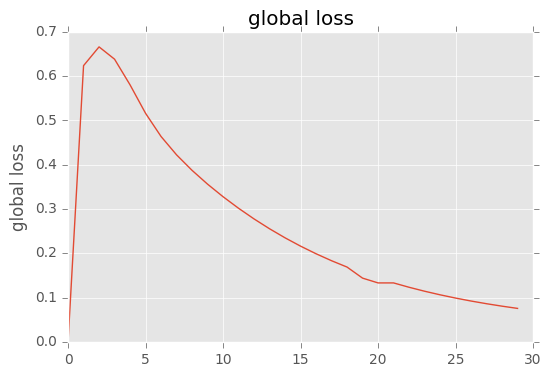

Train Accuracy: 1.000000
Validation Accuracy: 1.000000


In [41]:

# convert into 2 columns, isGood, isBad
from tflearn.data_utils import to_categorical
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

'''
        x_train 	: x training data
        y_train 	: y training labels
        x_val 		: x validation data
        y_val 		: y validation labels
'''

import tflearn
graph_to_use = tf.Graph()
with graph_to_use.as_default():
    # define neural net
    net = tflearn.input_data(shape=[None, x_train.shape[1]])
    net = tflearn.fully_connected(net, 50, activation='relu', name='relu_0')
    net = tflearn.fully_connected(net, 200, activation='relu', name='relu_1')
    net = tflearn.fully_connected(net, 10, activation='tanh', name='tanh')
    net = tflearn.fully_connected(net, 2, activation='softmax', name='softmax');
    net = tflearn.regression(net, learning_rate=0.005)
    show_graph(graph_to_use.as_graph_def())        

    import libs.nb_utils as nb_utils;
    nb_utils.show_graph(graph_to_use.as_graph_def())    

    # define model
    model = tflearn.DNN(net, tensorboard_verbose=3)

    class History(tflearn.callbacks.Callback):
        def on_train_begin(self, training_state):
            #self.losses = []
            self.acc_value =  []
            self.loss_value =  []

            self.val_acc =  []
            self.val_loss =  []

            self.global_acc =  []
            self.global_loss =  []

        def on_epoch_end(self, training_state):
            #self.losses.append(training_state.global_loss)

            self.acc_value.append(training_state.acc_value)
            self.loss_value.append(training_state.loss_value)

            self.val_acc.append(training_state.val_acc)
            self.val_loss.append(training_state.val_loss)

            self.global_acc.append(training_state.global_acc)
            self.global_loss.append(training_state.global_loss)

    # train
    history = History()
    model.fit(x_train, y_train, show_metric=True, batch_size=x_train.shape[0], n_epoch=30,run_id='ECG DNN',callbacks=[history],
          validation_set=(x_val,y_val), validation_batch_size=x_val.shape[0] )

    def plot(name,value): 
        #print(value)
        plt.plot(value)
        plt.title(name)
        plt.ylabel('epoch')
        plt.ylabel(name)
        plt.show()

    plot('train accuracy value',history.acc_value)
    plot('train loss value',history.loss_value)
    plot('validtion accuracy ',history.val_acc)
    plot('validation loss',history.val_loss)
    #plot('global acc',history.global_acc)
    plot('global loss',history.global_loss)

    # print accuracy statistics
    result = model.evaluate(x_train, y_train, batch_size=x_train.shape[0])
    accuracy_score = result[0]
    print("Train Accuracy: %f" % accuracy_score)

    result = model.evaluate(x_val, y_val, batch_size=x_val.shape[0])
    accuracy_score = result[0]
    print("Validation Accuracy: %f" % accuracy_score)



----- validation
classification
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       189
          1       0.99      0.97      0.98       175

avg / total       0.98      0.98      0.98       364

confusion matrix
----- training
classification
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       719
          1       0.98      1.00      0.99       733

avg / total       0.99      0.99      0.99      1452

confusion matrix
[[187   2]
 [  5 170]]


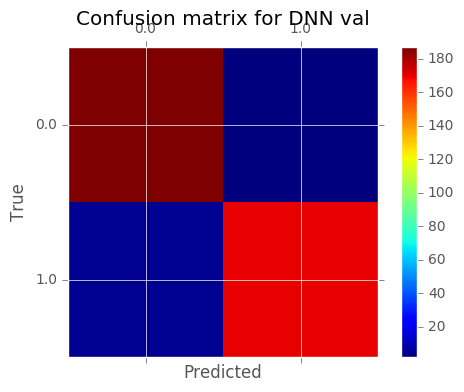

[[706  13]
 [  0 733]]


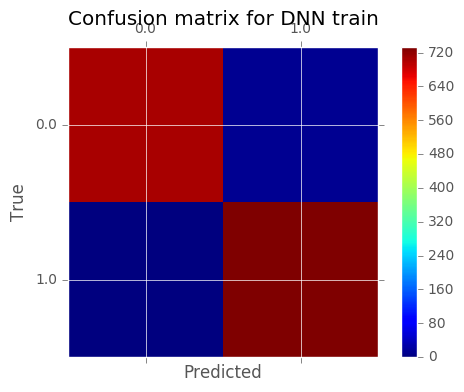

In [37]:

with graph_to_use.as_default():
    # print detail statistics
    import sklearn.metrics as skmetric
    from sklearn.metrics import classification_report

    print("----- validation")
    pred = model.predict(x_val)
    pred = np.around(np.asarray(pred))
    print("classification")
    print(classification_report(np.asarray(y_val.argmax(axis=1)), np.asarray(pred.argmax(axis=1))))
    print("confusion matrix")
    cm_val = skmetric.confusion_matrix(np.asarray(y_val.argmax(axis=1)), np.asarray(pred.argmax(axis=1)))

    print("----- training")
    pred = model.predict(x_train)
    pred = np.around(np.asarray(pred))
    print("classification")
    print(classification_report(y_train.argmax(axis=1), pred.argmax(axis=1)))
    print("confusion matrix")
    cm_train = (skmetric.confusion_matrix(np.asarray(y_train.argmax(axis=1)), np.asarray(pred.argmax(axis=1))))

    class_names = np.unique(y_train)
    confusion_matrices = [
    ( "DNN val", cm_val ),
    ( "DNN train", cm_train),
    ]
    %matplotlib inline
    draw_confusion_matrices(confusion_matrices,class_names)


In [ ]:
import webbrowser

# generate an URL
url = 'http://ubuntu:30000'
print(url)
webbrowser.open(url)

http://ubuntu:30000


False

In [ ]:
%run /opt/conda/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py --logdir=/tmp/tflearn_logs/ --port 30000

INFO:tensorflow:Starting TensorBoard in directory /home/jovyan/work
INFO:tensorflow:TensorBoard path_to_run is: {'/tmp/tflearn_logs': None}
INFO:tensorflow:Event Multiplexer initializing.
INFO:tensorflow:Event Multiplexer done initializing
INFO:tensorflow:TensorBoard reload process beginning
INFO:tensorflow:TensorBoard is tag: b'39'
Starting TensorBoard b'39' on port 30000
(You can navigate to http://172.17.0.39:30000)
INFO:tensorflow:Starting AddRunsFromDirectory: /tmp/tflearn_logs
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/ECG DNN
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/ECG DNN
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/0BK0V4
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/0BK0V4
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/OFQ15F
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/OFQ15F
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/KTIPGE
INFO: